# Importing The Necessary Dependencies

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from PIL import Image

# Loading and Splitting The Data

In [2]:
images = glob.glob("DATA++\\Mass\\*_FULL_*.png")
mask = glob.glob("DATA++\\Mass\\*_MASK_*.png")

In [3]:
print(images[:5])
print('-------------------')
print(mask[:5])

['DATA++\\Mass\\Mass-Test_P_00016_LEFT_CC_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00016_LEFT_MLO_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_CC_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_MLO_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00032_RIGHT_CC_FULL_PRE.png']
-------------------
['DATA++\\Mass\\Mass-Test_P_00016_LEFT_CC_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00016_LEFT_MLO_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_CC_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_MLO_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00032_RIGHT_CC_MASK_1___PRE.png']


In [4]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

,images,masks
0,DATA++\Mass\Mass-Test_P_00016_LEFT_CC_FULL_PRE...,DATA++\Mass\Mass-Test_P_00016_LEFT_CC_MASK_1__...
1,DATA++\Mass\Mass-Test_P_00016_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00016_LEFT_MLO_MASK_1_...
2,DATA++\Mass\Mass-Test_P_00017_LEFT_CC_FULL_PRE...,DATA++\Mass\Mass-Test_P_00017_LEFT_CC_MASK_1__...
3,DATA++\Mass\Mass-Test_P_00017_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00017_LEFT_MLO_MASK_1_...
4,DATA++\Mass\Mass-Test_P_00032_RIGHT_CC_FULL_PR...,DATA++\Mass\Mass-Test_P_00032_RIGHT_CC_MASK_1_...
5,DATA++\Mass\Mass-Test_P_00032_RIGHT_MLO_FULL_P...,DATA++\Mass\Mass-Test_P_00032_RIGHT_MLO_MASK_1...
6,DATA++\Mass\Mass-Test_P_00037_RIGHT_CC_FULL_PR...,DATA++\Mass\Mass-Test_P_00037_RIGHT_CC_MASK_1_...
7,DATA++\Mass\Mass-Test_P_00037_RIGHT_MLO_FULL_P...,DATA++\Mass\Mass-Test_P_00037_RIGHT_MLO_MASK_1...
8,DATA++\Mass\Mass-Test_P_00056_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00056_LEFT_MLO_MASK_1_...


In [5]:
data.shape

(1592, 2)

In [6]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [7]:
keras.utils.get_custom_objects()['dice_coef'] = dice_coef
keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss
keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss

In [8]:
model1 = tf.keras.models.load_model('unet_51_epochs.h5')
model2 = tf.keras.models.load_model('unet_model_256_30e.h5')
model3 = tf.keras.models.load_model('unet_model_256_31e.h5')

In [17]:
def mega_model(img) :
    
    pred1 = model1.predict(img, verbose=0)
    pred2 = model2.predict(img, verbose=0)
    pred3 = model3.predict(img, verbose=0)
    
    pred = (pred1 + pred2 + pred3) / 3
    return pred

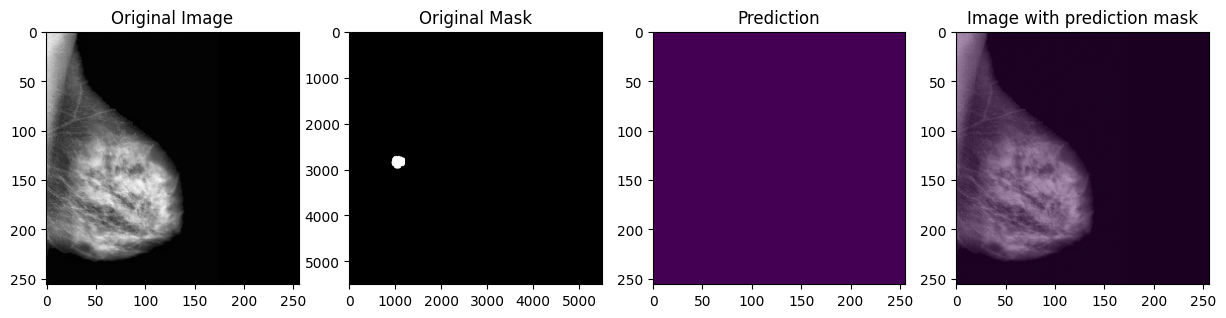

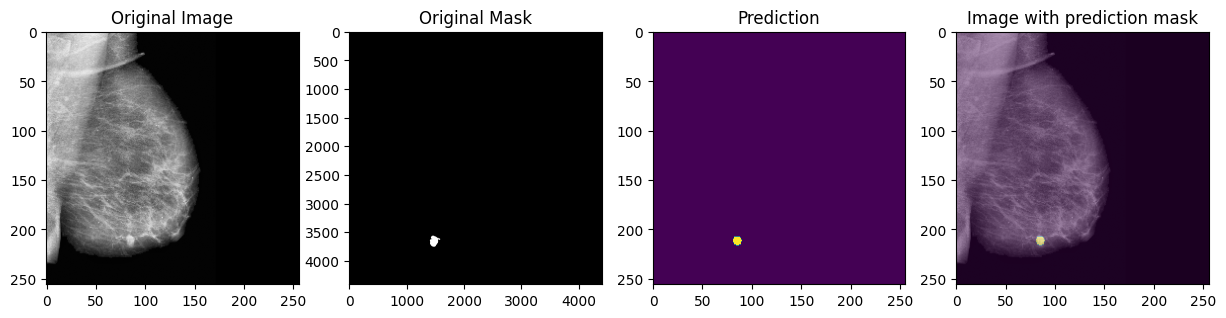

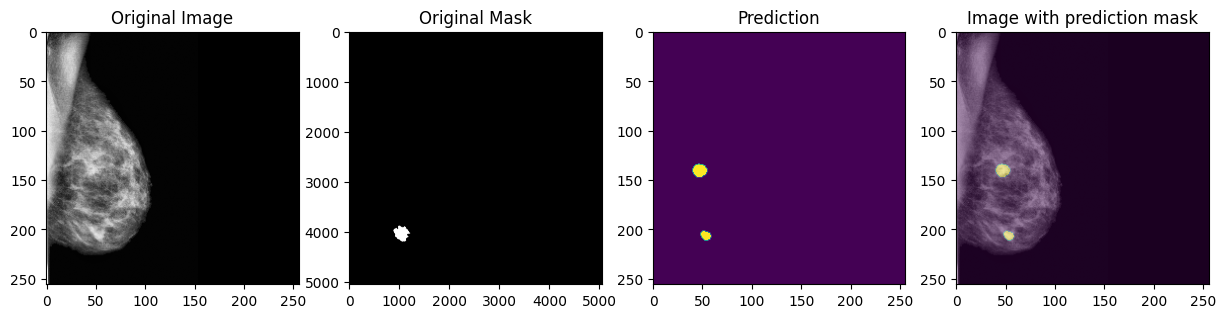

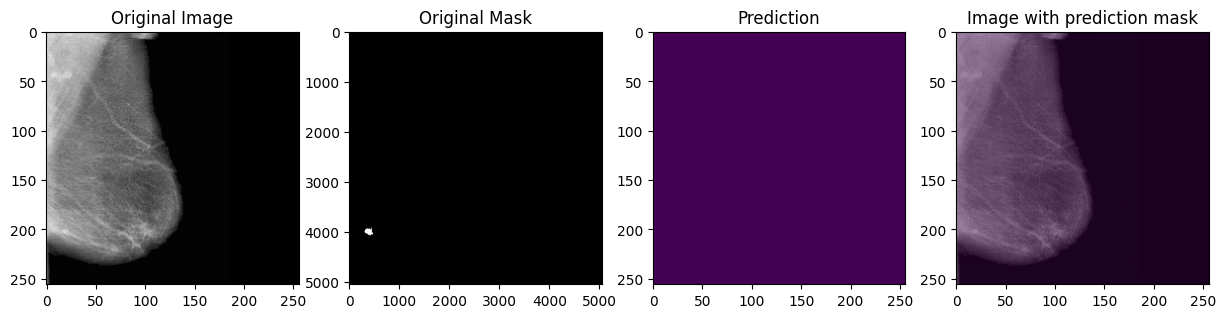

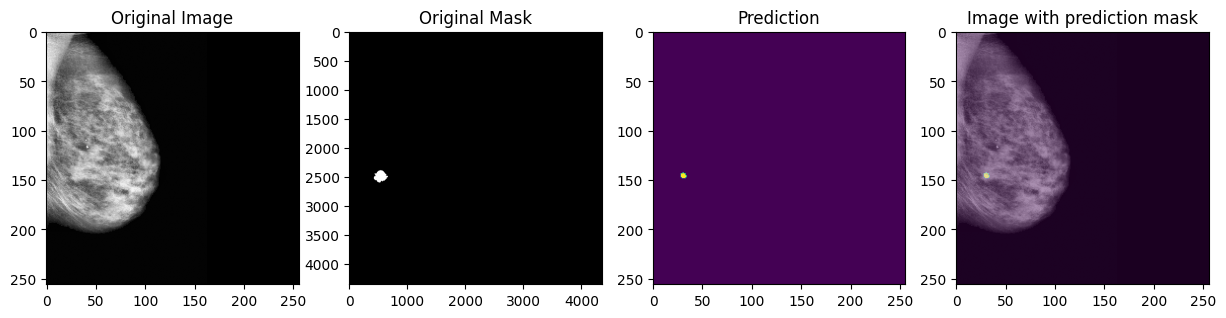

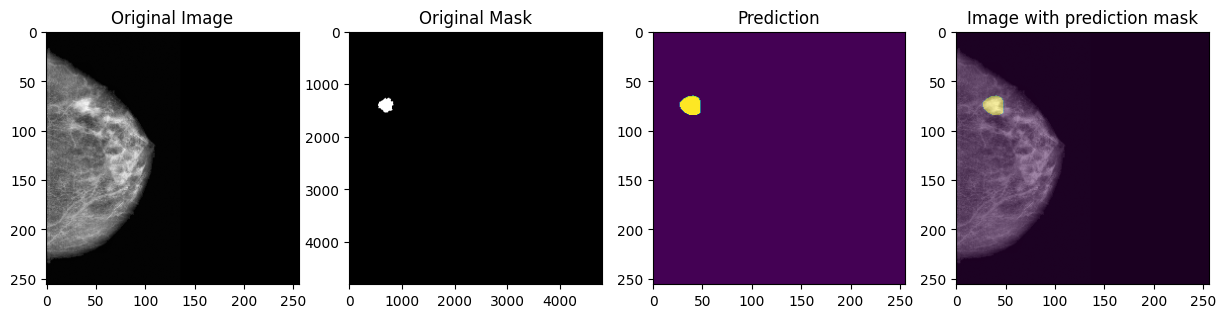

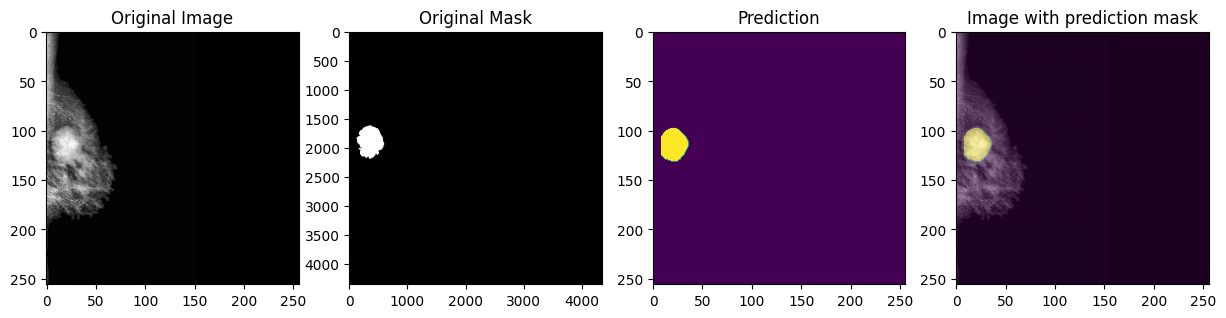

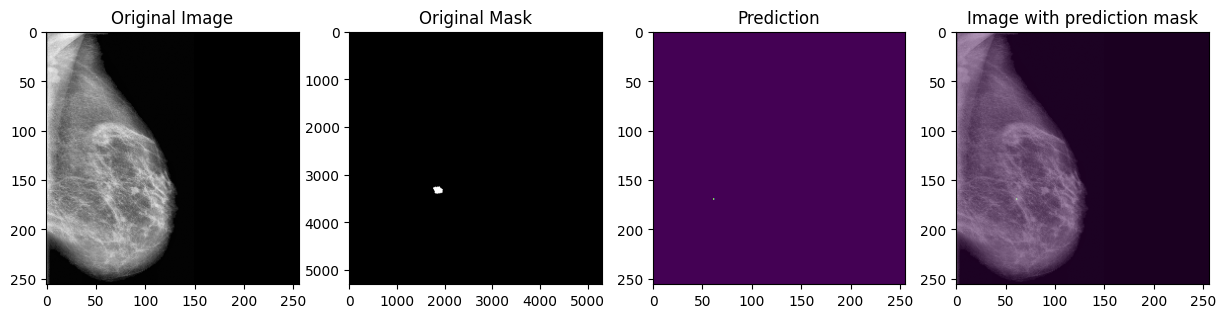

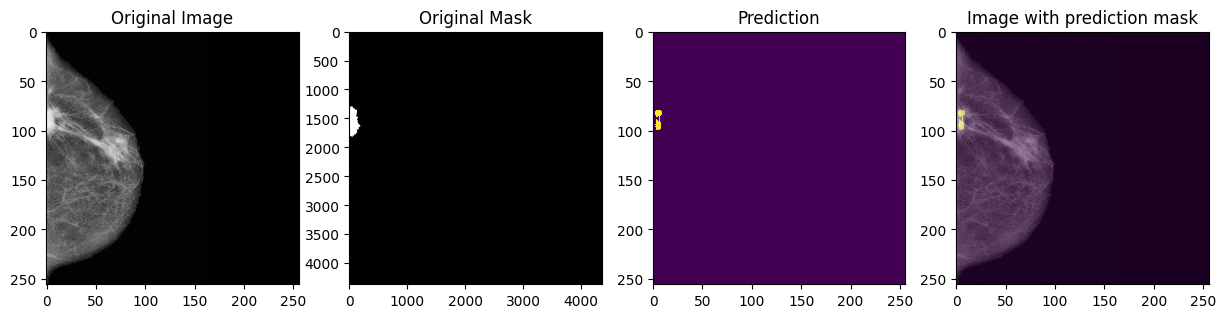

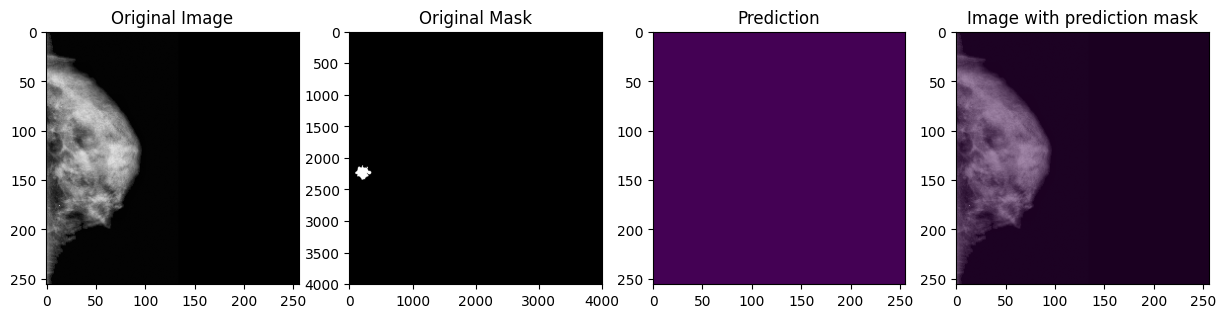

In [18]:
import cv2
for i in range(10):
    index=np.random.randint(1,len(data.index))
    img = cv2.imread(data['images'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    
    pred = mega_model(img)

    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(data['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred)>.5,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.show()